# Homework 4: CIFAR-10
Applied Neural Networks

## Create a CNN to classify CIFAR-10
Use the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset.

You can utilize `keras.datasets.cifar10.load_data()` to import the dataset as `numpy ndarrays` or `tfds.load('cifar10')` to import the dataset as `tf.data.Dataset`.

**You must utilize transfer learning and data augmentation.** Your grade will depend on the quality of your best model. Discuss the different models you tried. *Include all model parameters, accuracy, a confusion matrix, and sample misclassified images.*

I suggest using data pipelines to avoid a RAM resource exhaustion error. They can be implemented fairly easily in one of two ways: 
  1. Utilize a data_augmentation function and Dataset.map(data_augmentation) to augment your training tf.data.Dataset (will require `tf.data.Dataset`s), or
  2. Utilize Keras ImageDataGenerator, using the ImageDataGenerator to also do all preprocessing necessary and batch images (will require `np ndarray`s).

In [1]:
# using keras.datasets.cifar10.load_data() and Keras ImageDataGenerator

# imports
import numpy as np
import pandas as pd
from sklearn.utils.multiclass import unique_labels
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow
from tensorflow import keras

from keras import Sequential
# Models imported for transfer learing
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import ResNet50

# some of the import functions only work by putting tensorflow in them. Not sure why
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Activation, Dropout
from tensorflow.keras.utils import to_categorical

In [57]:
from keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [58]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.3)

In [59]:
X_train.shape, y_train.shape

((35000, 32, 32, 3), (35000, 1))

In [60]:
X_val.shape, y_val.shape

((15000, 32, 32, 3), (15000, 1))

In [61]:
X_test.shape, y_test.shape

((10000, 32, 32, 3), (10000, 1))

In [62]:
# 10 labels so the y shape will go from 1 to 10
# https://www.geeksforgeeks.org/python-keras-keras-utils-to_categorical/
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [63]:
y_train.shape, y_val.shape, y_test.shape

((35000, 10), (15000, 10), (10000, 10))

##Model 1 using VGG19

In [9]:
# Data Augmentation using the ImageDataGenerator
train_generator = ImageDataGenerator(rotation_range=2,
                                     horizontal_flip=True,
                                     zoom_range=0.1)
val_generator = ImageDataGenerator(rotation_range=2,
                                   horizontal_flip=True,
                                   zoom_range=0.1)
test_generator = ImageDataGenerator(rotation_range=2,
                                    horizontal_flip=True,
                                    zoom_range=0.1)

# fit the generators
train_generator.fit(X_train)
val_generator.fit(X_val)
test_generator.fit(X_test)

In [10]:
# Adjustable learning rate using keras callbacks
# error: monitor needed to be changed from val_accuracy to accuracy?
learning_rate_reduce = ReduceLROnPlateau(monitor='accuracy',
                                         factor=0.01,
                                         patience=3,
                                         min_lr=1e-5)

In [11]:
# first model uses the VGG19 model specifically designed for image recognition
model_1 = VGG19(include_top=False,
                weights='imagenet',
                input_shape=(32,32,3),
                classes=y_train.shape[1])

80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
# Add finishing layers to model 1
model = Sequential()
model.add(model_1)
model.add(Flatten())
model.add(Dense(1024, activation=('relu'), input_dim=512))
model.add(Dense(512, activation=('relu')))
model.add(Dense(256, activation=('relu')))
model.add(Dense(128, activation=('relu')))
model.add(Dense(10, activation=('softmax')))

model.compile(optimizer=SGD(lr=.001,
                            momentum=.9,
                            nesterov=False),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 10)                1

In [ ]:
# The data generator can be removed from the validation set in order to see
# different results.
# steps per epoch error fix
# https://stackoverflow.com/questions/59864408/tensorflowyour-input-ran-out-of-data
history_1 = model.fit(train_generator.flow(X_train, y_train, batch_size=128),
                    epochs=50,
                    #steps_per_epoch=len(X_train)//128,
                    validation_data=val_generator.flow(X_val, y_val, batch_size=128),
                    #validation_data=(X_val, y_val),
                    #validation_steps=250,
                    callbacks=[learning_rate_reduce],
                    #callbacks=[keras.callbacks.EarlyStopping(patience=5)],
                    verbose=1)

In [ ]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 9s 27ms/step - loss: 0.7957 - accuracy: 0.8627


[0.7956540584564209, 0.8626999855041504]

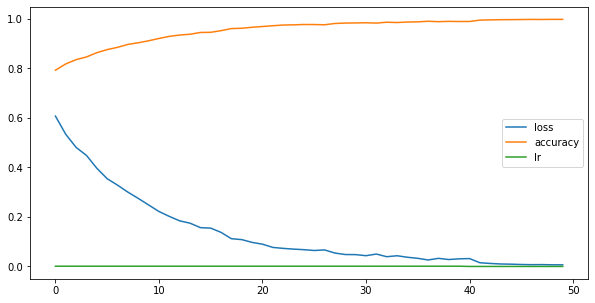

In [ ]:
pd.DataFrame(history_1.history).plot(figsize=(10,5))

**Model 1 Eval**</br>
This first model is pretty simple. It uses a lot of basic settings from the vgg19 structure. I also utilized the ReduceLROnPlateau from the callbacks api. </br>
The model seemed to be doing pretty well, but for some reason the Validation data sets weren't used when training. Because of that this model is mostly ignored. During the training phase, the accuracy got up to 99.8%, but without a validation set to test against, it doesn't mean a lot. When simply evaluating the model, it got around an 86% accuracy, which shows the model was just focused on accuracy when it should have been training off validation.</br></br>
In the ReduceLROnPlateau keras callbacks structure, the monitorign is set to 'accuracy' instead of 'val_accuracy' like it should be, but because there wasn't a validation set in the model, it needed to be changed.

In [12]:
model_2 = Sequential()
model_2.add(model_1)
model_2.add(Flatten())
model_2.add(Dense(1024, activation=('relu'), input_dim=512))
model_2.add(Dense(512, activation=('relu')))
model_2.add(Dense(256, activation=('relu')))
model_2.add(Dense(128, activation=('relu')))
model_2.add(Dense(10, activation=('softmax')))

model_2.compile(optimizer=SGD(lr=.001,
                            momentum=.9,
                            nesterov=False),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
history_2 = model_2.fit(train_generator.flow(X_train, y_train, batch_size=128),
                    epochs=50,
                    #steps_per_epoch=len(X_train)//128,
                    validation_data=val_generator.flow(X_val, y_val, batch_size=128),
                    #validation_data=(X_val, y_val),
                    #validation_steps=250,
                    #callbacks=[learning_rate_reduce])
                    callbacks=[keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/50
274/274 [==============================] - 52s 186ms/step - loss: 0.0917 - accuracy: 0.9733 - val_loss: 0.7361 - val_accuracy: 0.8483
Epoch 2/50
274/274 [==============================] - 51s 184ms/step - loss: 0.0289 - accuracy: 0.9904 - val_loss: 0.8248 - val_accuracy: 0.8421
Epoch 3/50
274/274 [==============================] - 50s 184ms/step - loss: 0.0337 - accuracy: 0.9893 - val_loss: 0.8383 - val_accuracy: 0.8387
Epoch 4/50
274/274 [==============================] - 51s 184ms/step - loss: 0.0290 - accuracy: 0.9908 - val_loss: 0.7373 - val_accuracy: 0.8537
Epoch 5/50
274/274 [==============================] - 51s 185ms/step - loss: 0.0264 - accuracy: 0.9918 - val_loss: 0.8271 - val_accuracy: 0.8445
Epoch 6/50
274/274 [==============================] - 51s 184ms/step - loss: 0.0256 - accuracy: 0.9917 - val_loss: 0.8163 - val_accuracy: 0.8432


In [13]:
# needed to be run because colab felt like disconnecting and I lost my model, nice
history_22 = model_2.fit(train_generator.flow(X_train, y_train, batch_size=128),
                    epochs=50,
                    validation_data=val_generator.flow(X_val, y_val, batch_size=128),
                    callbacks=[keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/50
274/274 [==============================] - 63s 188ms/step - loss: 1.5058 - accuracy: 0.4597 - val_loss: 0.9554 - val_accuracy: 0.6673
Epoch 2/50
274/274 [==============================] - 51s 187ms/step - loss: 0.8642 - accuracy: 0.7040 - val_loss: 0.7652 - val_accuracy: 0.7373
Epoch 3/50
274/274 [==============================] - 51s 185ms/step - loss: 0.7079 - accuracy: 0.7587 - val_loss: 0.6574 - val_accuracy: 0.7748
Epoch 4/50
274/274 [==============================] - 51s 184ms/step - loss: 0.6036 - accuracy: 0.7939 - val_loss: 0.6488 - val_accuracy: 0.7809
Epoch 5/50
274/274 [==============================] - 50s 184ms/step - loss: 0.5253 - accuracy: 0.8213 - val_loss: 0.6299 - val_accuracy: 0.7869
Epoch 6/50
274/274 [==============================] - 50s 184ms/step - loss: 0.4810 - accuracy: 0.8355 - val_loss: 0.5748 - val_accuracy: 0.8137
Epoch 7/50
274/274 [==============================] - 50s 182ms/step - loss: 0.4302 - accuracy: 0.8501 - val_loss: 0.5655 - val_ac

In [ ]:
model_2.evaluate(X_test, y_test)

313/313 [==============================] - 8s 25ms/step - loss: 0.8467 - accuracy: 0.8473


[0.8467130064964294, 0.8472999930381775]

In [14]:
model_2.evaluate(X_test, y_test)

313/313 [==============================] - 9s 26ms/step - loss: 0.5965 - accuracy: 0.8342


[0.5965118408203125, 0.8342000246047974]

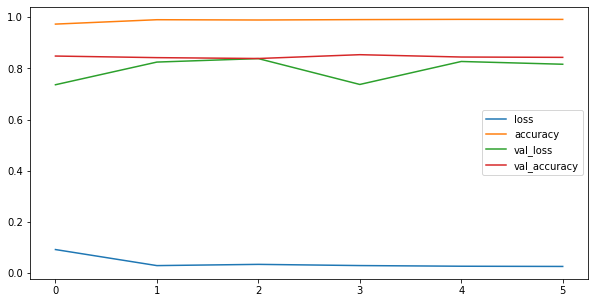

In [ ]:
pd.DataFrame(history_2.history).plot(figsize=(10,5))

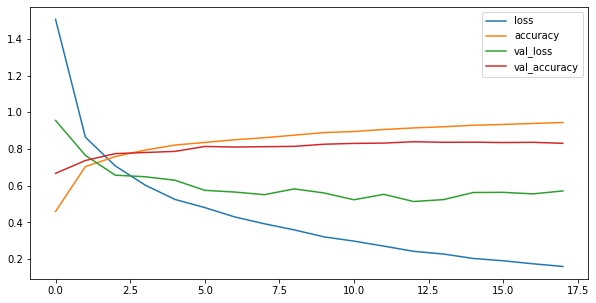

In [15]:
pd.DataFrame(history_22.history).plot(figsize=(10,5))

##**Confusion Matrix**

In [ ]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
# https://pythonbasics.org/seaborn-heatmap/ 

labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
temp_X_test = X_test
temp_y_test = y_test
predictions = model_2.predict(temp_X_test)

In [ ]:
predictions = np.argmax(predictions, axis=1)

In [ ]:
temp_y_test = np.argmax(y_test, axis=1)

In [ ]:
predictions

array([3, 8, 8, ..., 5, 1, 7])

In [ ]:
temp_y_test

array([3, 8, 8, ..., 5, 1, 7])

In [ ]:
cm = confusion_matrix(temp_y_test, predictions)

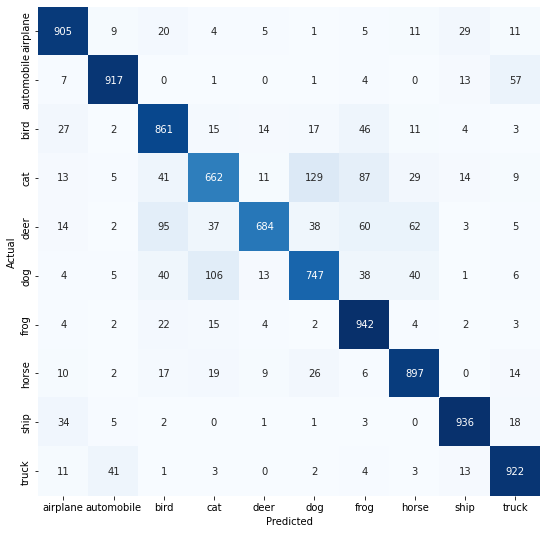

In [ ]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, cbar=False, xticklabels=labels, yticklabels=labels, fmt='d', annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

##**Misclassified Images**

In [22]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
temp_X_test = X_test
temp_y_test = y_test
predictions = model_2.predict(temp_X_test)

In [23]:
temp_X_test.shape

(10000, 32, 32, 3)

In [24]:
predictions.shape

(10000, 10)

In [26]:
predictions = np.argmax(predictions, axis=1)
temp_y_test = np.argmax(y_test, axis=1)

In [31]:
temp_y_test = temp_y_test.astype(int)
predictions = predictions.astype(int)

In [34]:
predictions

array([3, 8, 8, ..., 5, 1, 7])

In [35]:
temp_y_test

array([3, 8, 8, ..., 5, 1, 7])

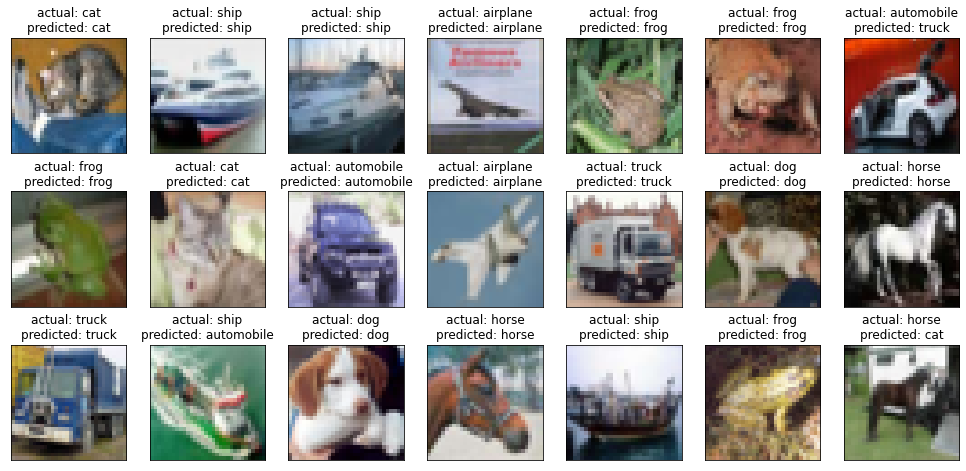

In [46]:
# misclassified images
fig, axes = plt.subplots(ncols=7, nrows=3, sharex=False,
                         sharey=True, figsize=(17, 8))

# just change index number to start from different point in testing data
index = 0
for i in range(3):
    for j in range(7):
        #axes[i,j].set_title('actual:' + labels[temp_y_test[index][0]] + '\n' + 'predicted:' + labels[predictions[index][0]])
        #axes[i,j].set_title('actual:' + labels[temp_y_test[index][0]] + '\n')
        axes[i,j].set_title('actual: ' + labels[temp_y_test[index]] + '\npredicted: ' + labels[predictions[index]])
        axes[i,j].imshow(X_test[index], cmap='gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        index += 1
plt.show()

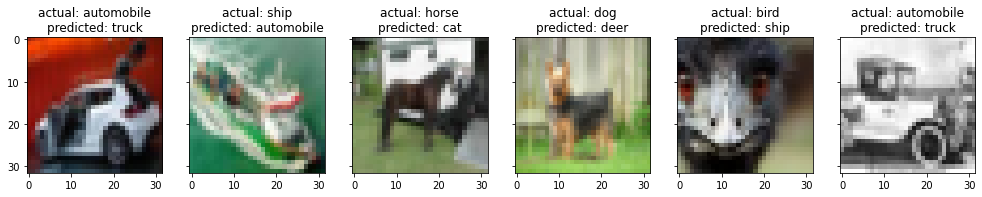

In [54]:
# 6 15 20 24 35 37
# just from searching through what images were falsely predicted, I took the 
# first 6 found and manually displayed them this way
fig, axes = plt.subplots(ncols=6, nrows=1, sharex=False,
                         sharey=True, figsize=(17, 8))

axes[0].set_title('actual: ' + labels[temp_y_test[6]] + '\npredicted: ' + labels[predictions[6]])
axes[0].imshow(temp_X_test[6])

axes[1].set_title('actual: ' + labels[temp_y_test[15]] + '\npredicted: ' + labels[predictions[15]])
axes[1].imshow(temp_X_test[15])

axes[2].set_title('actual: ' + labels[temp_y_test[20]] + '\npredicted: ' + labels[predictions[20]])
axes[2].imshow(temp_X_test[20])

axes[3].set_title('actual: ' + labels[temp_y_test[24]] + '\npredicted: ' + labels[predictions[24]])
axes[3].imshow(temp_X_test[24])

axes[4].set_title('actual: ' + labels[temp_y_test[35]] + '\npredicted: ' + labels[predictions[35]])
axes[4].imshow(temp_X_test[35])

axes[5].set_title('actual: ' + labels[temp_y_test[37]] + '\npredicted: ' + labels[predictions[37]])
axes[5].imshow(temp_X_test[37])

**Model 1 Eval**</br>
The second model used was very similar to the first model, but it contained validation metrics. The model's architecture is made up of the vgg19 transfer learning model, then 4 Dense layers afterwards with a softmax final Dense layer. Finally some basic Data Augmentation was used while training. ReduceLROnPlateau from the keras callbacks was not utilized in the final model.</br>
Accuracy: Final Validation accuracy ~84%</br>
**Confusion Matrix**</br>
The confusion matrix reveals that certain categories get predicted wrong more often than others. These are the cat, deer, and dog images. While all of the other categories remain around a 90% accuracy, these 3 are around a high 60% accuracy. Perhaps it is because they are all 4 legged animals, but horses aren't as low with accuracy, so I'm unsure. </br>
**Misclassified Images**</br>
I simply listed the first 6 misclassified images from the X_test dataset. Some of the misclassifications make sense, while others are a little confusing. Images 3 and 4 are 4 legged animals, so it makes sense how they could be confused. Image 5 is a close up image of a bird's face while most bird images contain the birds body, so it makes sense why it would be confused. Images 1 and 6 are both automobiles confused for trucks, which is a close comparison again. And finally image 2 might just be too hard to tell for the model.

##Model 2 using ResNet50

In [64]:
# Second model uses ResNet50, which is a deeper and more compelx model than the previous VGG19
resnet_model = ResNet50(include_top=False,
                   weights='imagenet',
                   input_shape=(32,32,3),
                   classes=y_train.shape[1])

94781440/94765736 [==============================] - 1s 0us/step


In [67]:
model_2 = Sequential()
model_2.add(resnet_model)
model_2.add(Flatten())

model_2.add(Dense(4000, activation=('relu'), input_dim=512))
model_2.add(Dense(2000, activation=('relu'))) 
model_2.add(Dropout(.2))
model_2.add(Dense(1000, activation=('relu'))) 
model_2.add(Dropout(.15))
model_2.add(Dense(500, activation=('relu')))
model_2.add(Dropout(.1))
model_2.add(Dense(10, activation=('softmax')))

model_2.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [68]:
model_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_15 (Dense)            (None, 4000)              8196000   
                                                                 
 dense_16 (Dense)            (None, 2000)              8002000   
                                                                 
 dropout_6 (Dropout)         (None, 2000)              0         
                                                                 
 dense_17 (Dense)            (None, 1000)              2001000   
                                                                 
 dropout_7 (Dropout)         (None, 1000)             

In [69]:
# fit the model using ResNet50
history_3 = model_2.fit(train_generator.flow(X_train, y_train, batch_size=128),
                        epochs=50,
                        validation_data=(X_val, y_val),
                        callbacks=[keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/50
274/274 [==============================] - 79s 249ms/step - loss: 1.4686 - accuracy: 0.5090 - val_loss: 1.7583 - val_accuracy: 0.5543
Epoch 2/50
274/274 [==============================] - 66s 240ms/step - loss: 0.9441 - accuracy: 0.6986 - val_loss: 1.4048 - val_accuracy: 0.6213
Epoch 3/50
274/274 [==============================] - 57s 208ms/step - loss: 0.7940 - accuracy: 0.7478 - val_loss: 1.2533 - val_accuracy: 0.6487
Epoch 4/50
274/274 [==============================] - 57s 207ms/step - loss: 0.7215 - accuracy: 0.7695 - val_loss: 0.9009 - val_accuracy: 0.7241
Epoch 5/50
274/274 [==============================] - 57s 207ms/step - loss: 0.6965 - accuracy: 0.7807 - val_loss: 1.4716 - val_accuracy: 0.6505
Epoch 6/50
274/274 [==============================] - 65s 239ms/step - loss: 0.6423 - accuracy: 0.7959 - val_loss: 0.8875 - val_accuracy: 0.7273
Epoch 7/50
274/274 [==============================] - 57s 207ms/step - loss: 0.5828 - accuracy: 0.8159 - val_loss: 1.2211 - val_ac

In [72]:
model_2.evaluate(X_test, y_test)

313/313 [==============================] - 9s 30ms/step - loss: 0.9660 - accuracy: 0.7480


[0.9660367965698242, 0.7480000257492065]

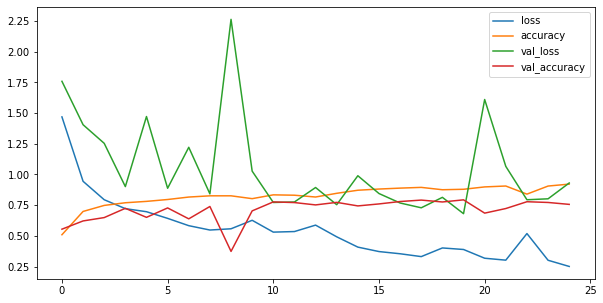

In [73]:
pd.DataFrame(history_3.history).plot(figsize=(10,5))

##**Confusion Matrix**

In [74]:
# Set up the confusion matrix for this interesting model...
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
temp_X_test = X_test
temp_y_test = y_test
predictions = model_2.predict(temp_X_test)

predictions = np.argmax(predictions, axis=1)
temp_y_test = np.argmax(y_test, axis=1)

cm = confusion_matrix(temp_y_test, predictions)

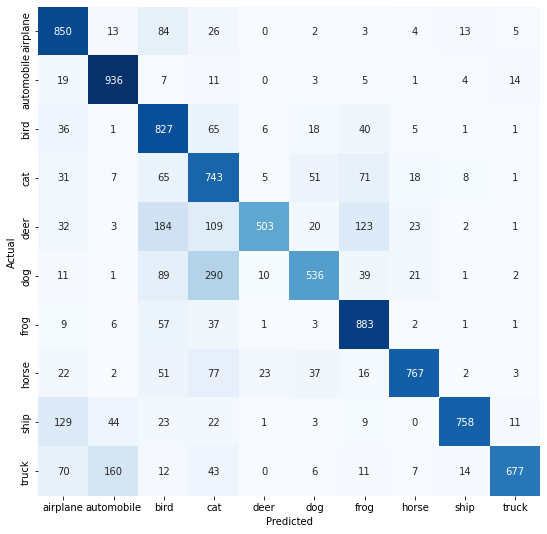

In [75]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, cbar=False, xticklabels=labels, yticklabels=labels, fmt='d', annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

##**Misclassified Images**

In [76]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
temp_X_test = X_test
temp_y_test = y_test
predictions = model_2.predict(temp_X_test)

In [78]:
predictions = np.argmax(predictions, axis=1)
temp_y_test = np.argmax(y_test, axis=1)

temp_y_test = temp_y_test.astype(int)
predictions = predictions.astype(int)

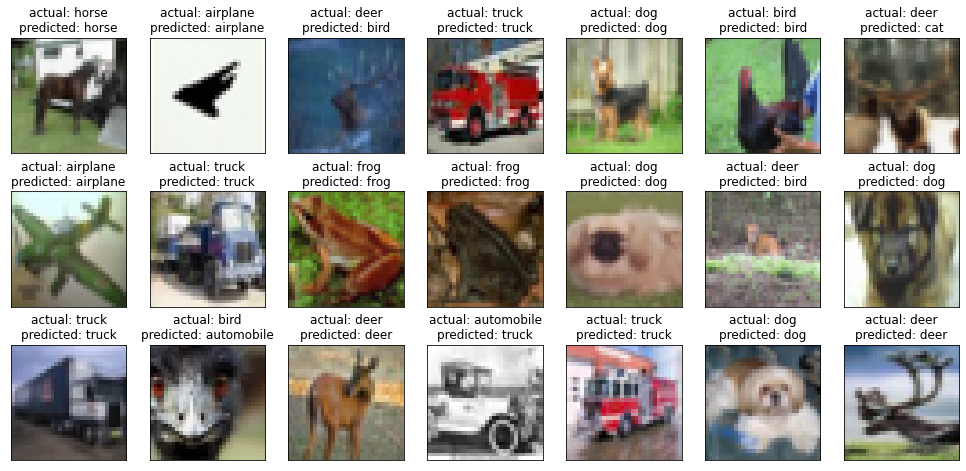

In [80]:
# misclassified images
fig, axes = plt.subplots(ncols=7, nrows=3, sharex=False,
                         sharey=True, figsize=(17, 8))

# just change index number to start from different point in testing data
index = 20
for i in range(3):
    for j in range(7):
        axes[i,j].set_title('actual: ' + labels[temp_y_test[index]] + '\npredicted: ' + labels[predictions[index]])
        axes[i,j].imshow(X_test[index], cmap='gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        index += 1
plt.show()

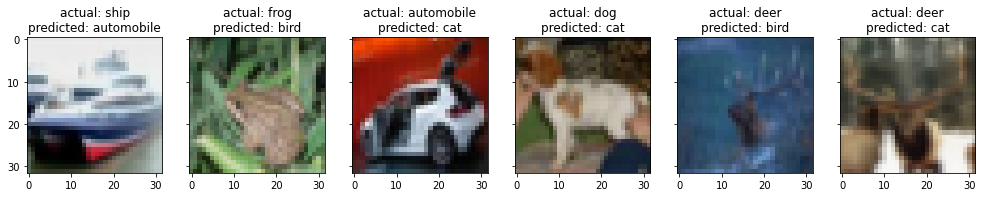

In [81]:
# 1 4 6 12 22 26
fig, axes = plt.subplots(ncols=6, nrows=1, sharex=False,
                         sharey=True, figsize=(17, 8))

axes[0].set_title('actual: ' + labels[temp_y_test[1]] + '\npredicted: ' + labels[predictions[1]])
axes[0].imshow(temp_X_test[1])

axes[1].set_title('actual: ' + labels[temp_y_test[4]] + '\npredicted: ' + labels[predictions[4]])
axes[1].imshow(temp_X_test[4])

axes[2].set_title('actual: ' + labels[temp_y_test[6]] + '\npredicted: ' + labels[predictions[6]])
axes[2].imshow(temp_X_test[6])

axes[3].set_title('actual: ' + labels[temp_y_test[12]] + '\npredicted: ' + labels[predictions[12]])
axes[3].imshow(temp_X_test[12])

axes[4].set_title('actual: ' + labels[temp_y_test[22]] + '\npredicted: ' + labels[predictions[22]])
axes[4].imshow(temp_X_test[22])

axes[5].set_title('actual: ' + labels[temp_y_test[26]] + '\npredicted: ' + labels[predictions[26]])
axes[5].imshow(temp_X_test[26])

**Model 2 Eval**</br>
Model uses the ResNet50 model then 4 Dense layers combined with Dropout layers with a final softmax output layer. Image Data Generation is used during training in order to stop the model from becoming overfit. This model surprisingly performed much worse than the first model. Maybe that is because the VGG19 is specifically made for images while the ResNet50 isn't. The model trained very chaotically and the different metrics were all over the board throughout. The model is very unstable and quite likely overfit. 
</br>
Accuracy: Final ~75%</br>
**Confusion Matrix**</br>
The confusion matrix shows that many of the same categories that the earlier model had trouble with are also difficult for this model. Deer are once again the worst performing for some reason, with the other 4 legged animals following. There was also more overlap and confusion between the different vehicles for this model as well. </br>
**Misclassified Images**</br>
The misclassified images from this model are worse guesses than previous models. mistaking a car for a cat and a frog for a bird are much more glaring issues than 2 similar looking 4 legged animals. Looking at some of the misidentified images of deer, I think that one of the reasons it may be hardest to identify them is because their antlers may get lost through all of the filtering and identifying, but that is just a hunch.